In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl



In [3]:
sns.set_style("darkgrid")
sns.set_palette("Pastel1")
sns.set_context("notebook")
pd.options.display.max_rows = 200

%config InlineBackend.figure_format='retina'
mpl.rcParams['figure.dpi'] = 90


The original dataset contains 85 columns, mostly categorical. My goal in this notebook is to investigate which factors contribute to a developer's job satisfaction. With this in mind, I think that only some of the original 85 columns are actually relevant to our analysis. To avoid cluttering the notebook, I already excluded the features that I don't want to investigate further, such as the developer's learning goals for 2020 and some personal information like sexuality and ethnicity - though I decided to keep the *Gender* column.

The survey includes both a column for "Career Satisfaction" and one for "Job Satisfaction". I've decided to focus on analyzing on **job satisfaction** out of the two.

> I've hidden some of the code cells in this notebook to streamline the blog post. You can find the complete code in this repository:

## Importing data and initial analysis

In [4]:
survey_raw = pd.read_csv("data/survey_results_public_reduced.csv", header = 0, sep = ';', encoding = 'ISO 8859-1')

In [5]:
survey_raw.head()

,MainBranch,Hobbyist,OpenSourcer,Employment,Country,EdLevel,UndergradMajor,EduOther,OrgSize,DevType,...,JobSat,MgrWant,ConvertedComp,WorkWeekHrs,WorkPlan,WorkChallenge,WorkRemote,ImpSyn,Age,Gender
0,I am a student who is learning to code,Yes,Never,"Not employed, and not looking for work",United Kingdom,Primary/elementary school,NaN,"Taught yourself a new language, framework, or ...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,Man
1,I am a student who is learning to code,No,Less than once per year,"Not employed, but looking for work",Bosnia and Herzegovina,"Secondary school (e.g. American high school, G...",NaN,Taken an online course in programming or softw...,NaN,"Developer, desktop or enterprise applications;...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,Man
2,"I am not primarily a developer, but I write co...",Yes,Never,Employed full-time,Thailand,"Bachelors degree (BA, BS, B.Eng., etc.)",Web development or web design,"Taught yourself a new language, framework, or ...",100 to 499 employees,"Designer;Developer, back-end;Developer, front-...",...,Slightly satisfied,Not sure,8820.0,40.0,There's no schedule or spec; I work on what se...,Distracting work environment;Inadequate access...,Less than once per month / Never,Average,28.0,Man
3,I am a developer by profession,No,Never,Employed full-time,United States,"Bachelors degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",Taken an online course in programming or softw...,100 to 499 employees,"Developer, full-stack",...,Slightly satisfied,Not sure,61000.0,80.0,There's no schedule or spec; I work on what se...,NaN,Less than once per month / Never,A little below average,22.0,Man
4,I am a developer by profession,Yes,Once a month or more often,Employed full-time,Ukraine,"Bachelors degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",Taken an online course in programming or softw...,"10,000 or more employees","Academic researcher;Developer, desktop or ente...",...,Slightly dissatisfied,No,NaN,55.0,There is a schedule and/or spec (made by me or...,Being tasked with non-development work;Inadequ...,A few days each month,A little above average,30.0,Man


Let's take a look at the **23 columns** we have available for the analysis.

In [6]:
print(survey_raw.columns)
print(survey_raw.info(verbose = False))

Index(['MainBranch', 'Hobbyist', 'OpenSourcer', 'Employment', 'Country',
       'EdLevel', 'UndergradMajor', 'EduOther', 'OrgSize', 'DevType',
       'YearsCode', 'YearsCodePro', 'CareerSat', 'JobSat', 'MgrWant',
       'ConvertedComp', 'WorkWeekHrs', 'WorkPlan', 'WorkChallenge',
       'WorkRemote', 'ImpSyn', 'Age', 'Gender'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88883 entries, 0 to 88882
Columns: 23 entries, MainBranch to Gender
dtypes: float64(3), object(20)
memory usage: 15.6+ MB
None


As we can see, the dataset contains almost 90000 answers to the survey. However, **not all survey takers were developers**: the survey also includes student, ex-devs and other categories. To figure out how many of these answers are from working developers, we can look at the *MainBranch* column.

#### Selecting data of interest

I will remove from the dataset:
- People who are not currently developers (e.g. student, ex devs)
- Part-time developers
- Answers from developer with less than 1 year of coding experience (included outside of work)


In [7]:
# only prof. developers
survey_dev = survey_raw[(survey_raw['MainBranch'] == 'I am a developer by profession')]

# exclude part time
survey_dev = survey_dev[(survey_dev['Employment'] == 'Employed full-time')
| (survey_dev['Employment'] == 'Independent contractor, freelancer, or self-employed') ]

# exclude less than 1 year coding
survey_dev = survey_dev[(survey_dev['YearsCodePro'] != 'Less than 1 year') | (survey_dev['YearsCode'] != 'Less than 1 year') ]


In [8]:
survey_dev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61373 entries, 3 to 88330
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MainBranch      61373 non-null  object 
 1   Hobbyist        61373 non-null  object 
 2   OpenSourcer     61373 non-null  object 
 3   Employment      61373 non-null  object 
 4   Country         61373 non-null  object 
 5   EdLevel         60297 non-null  object 
 6   UndergradMajor  56647 non-null  object 
 7   EduOther        58794 non-null  object 
 8   OrgSize         59861 non-null  object 
 9   DevType         60824 non-null  object 
 10  YearsCode       60999 non-null  object 
 11  YearsCodePro    60911 non-null  object 
 12  CareerSat       61373 non-null  object 
 13  JobSat          61096 non-null  object 
 14  MgrWant         51544 non-null  object 
 15  ConvertedComp   48528 non-null  float64
 16  WorkWeekHrs     55834 non-null  float64
 17  WorkPlan        59373 non-null 

We're down to about **60000 rows**. Also, since Job Satisfaction is out target variable, it's best to drop the rows for which it's null - they're just a few hundred.

### Utility functions

In [9]:
#utility plotting function 
def plotJobSatisfaction(column, target = "JobSat", width = 5, height = 5, bartype = 'bar', norm = True):
    props = survey_dev.groupby(column)[target].value_counts(normalize=norm).unstack()
    props.plot(kind= bartype, stacked='True', figsize = (width,height),edgecolor = "none")
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left");

In [96]:
def grouped_bars_fraction( x, y,hue,df = survey_dev):
    df[x].groupby(df[hue]).value_counts(normalize=True).rename(y).reset_index().pipe((sns.barplot, "data"), x=x, y=y, hue=hue)

In [60]:
def lollipop(x,y,xshift=-0.2,yshift=7):
    plt.stem(y,use_line_collection = True)
    plt.xticks(range(0,len(x)), x);
    for index, value in enumerate(y):
        plt.text(index + xshift,value + yshift ,str(value))

In [23]:
def percentageSatisfied(column, dataset = survey_dev, rounding = 1):
    data = dataset.dropna(subset = [column])
    grouped_data_sat = survey_dev.loc[survey_dev.Satisfaction=='Satisfied'].groupby([column])[column].count()
    grouped_data_tot = survey_dev.groupby([column])[column].count()
    return np.round(grouped_data_sat/grouped_data_tot*100,rounding)

## Exploratory data analysis

First of all, I'd like to know the distribution of our target variable - **Job Satisfaction**. 

In [11]:
survey_dev['JobSat'].value_counts()

Slightly satisfied                    20918
Very satisfied                        19452
Slightly dissatisfied                  9168
Neither satisfied nor dissatisfied     7392
Very dissatisfied                      4166
Name: JobSat, dtype: int64

Seems like our survery data is skewed towards higher job satisfaction: about 66% of the respondents are satisfied with their career, and about 22% report being slightly or very dissatisfied. The rest are in the middle of the scale. That's a pretty encouraging result! It seems like, at least in this sample, developers are mostly content in their jobs. 

I want to encode a new feature that simplifies the "satisfaction" variable, so I'm using the pandas .**map** method to assign each of the 5 values to one new value out of Satisfied, Unsatisfied or Neutral.

In [12]:
survey_dev['Satisfaction'] = survey_dev['JobSat'].map({'Very satisfied':'Satisfied', 'Slightly satisfied':'Satisfied',
                                                'Neither satisfied nor dissatisfied': 'Neutral',
                                               'Slightly dissatisfied': 'Unsatisfied', 'Very dissatisfied':'Unsatisfied' })
print("Are you satisfied with your job as a developer?")
survey_dev['Satisfaction'].value_counts()

Are you satisfied with your job as a developer?


Satisfied      40370
Unsatisfied    13334
Neutral         7392
Name: Satisfaction, dtype: int64

### Demographics

#### Country

In [13]:
country_count = survey_dev['Country'].unique().size
print(f"There are {country_count} different countries in the survey.")

There are 167 different countries in the survey.


In [14]:
# Country 
survey_dev['CountryCat'] = survey_dev['Country']
survey_dev['CountryCat'] = np.where(((survey_dev['Country'] != 'United States') 
                                     & (survey_dev['Country'] != 'United Kingdom')
                                     & (survey_dev['Country'] != 'India'))
                                    , 'Other', survey_dev['Country'])

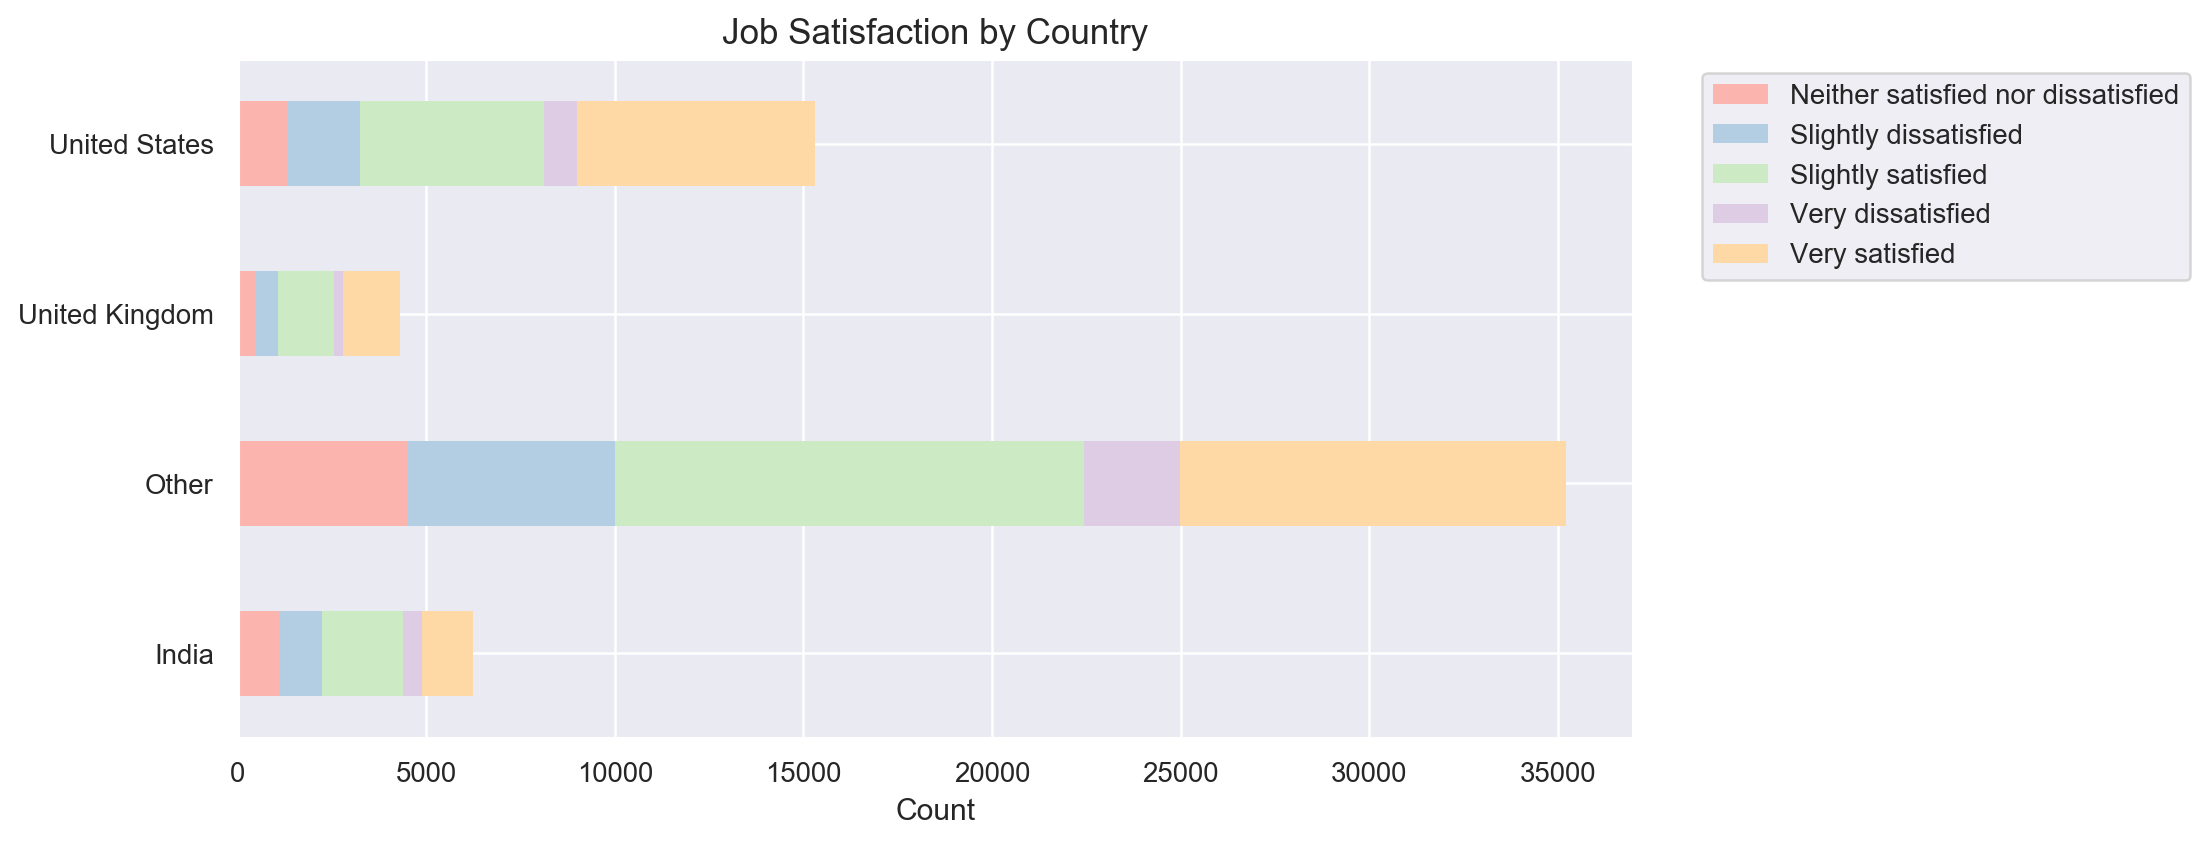

In [15]:
plotJobSatisfaction("CountryCat", width = 10, norm = False,bartype = 'barh')
plt.title('Job Satisfaction by Country',fontsize = 14);
plt.xlabel('Count');
plt.ylabel('');

Let's start off with a tricky one. As you see, the majority of respondents actually aren't from the United States or UK. India is very well represented, along with other countries all over the world.
The reason this makes the analysis tricky is that it basically stops us from using the *Compensation* column for our analysis. Since compensation has been converted to US dollars for all survey respondents, it cannot give us any reliable information since the same amount of money will lead to wildly different purchasing powers in different countries.

#### Age

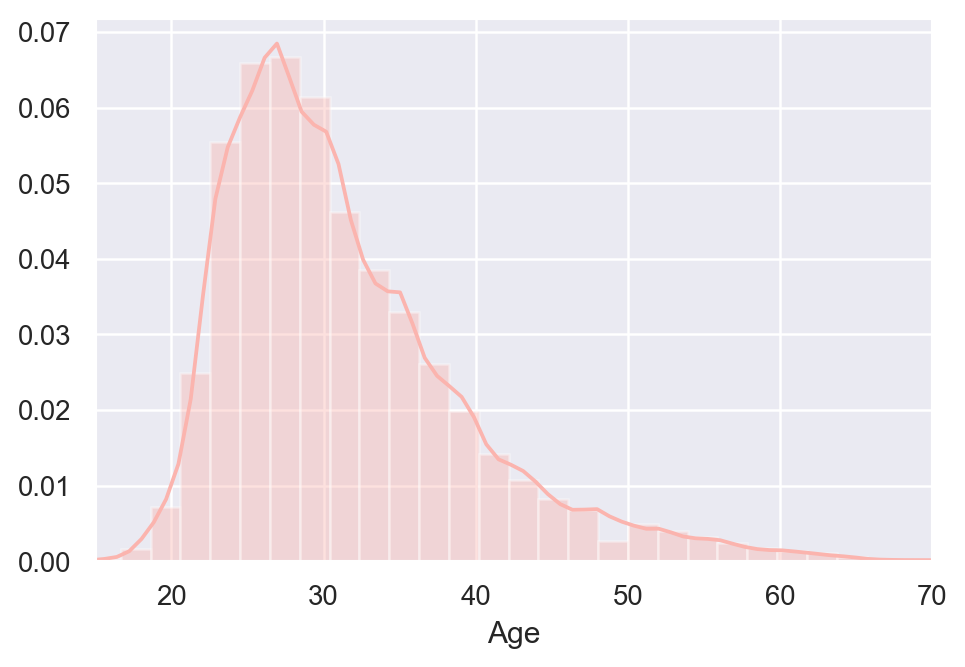

In [16]:
#Age
sns.distplot(survey_dev['Age'])
plt.xlim(15, 70);


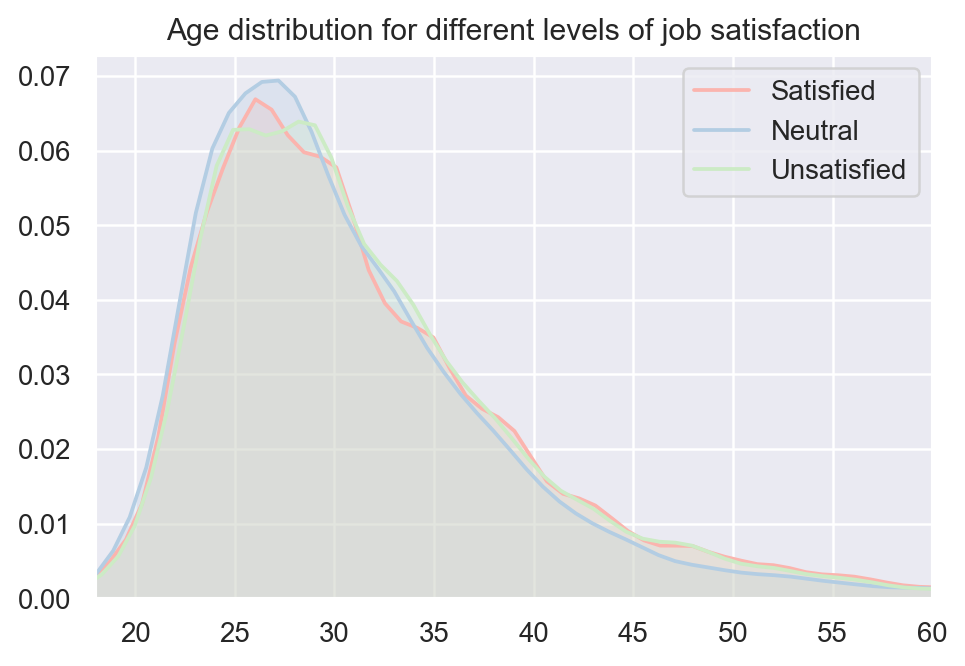

In [17]:
sat_values = ['Satisfied', 'Neutral', 'Unsatisfied']
for value in sat_values:
    data_p = survey_dev.loc[survey_dev['Satisfaction'] == value]['Age']
    sns.kdeplot(data = data_p, shade = True)
    
plt.xlim((18,60));
plt.title('Age distribution for different levels of job satisfaction')
plt.legend(sat_values);

There doesn't seem to be much of a pattern here, the three distributions all almost match the overall age distribution.

#### Gender

In [18]:
#Gender
print(survey_dev['Gender'].value_counts() )

print('\nNumber of NULL gender values: ' + str(survey_dev['Gender'].isnull().sum()))

man_p = 100*(len(survey_dev[survey_dev['Gender'] == 'Man']) / len(survey_dev))
print('Percentage of developers who identify as men: ' + str(np.round(man_p,2)) + '%')


Man                                                            54731
Woman                                                           4000
Non-binary, genderqueer, or gender non-conforming                359
Man;Non-binary, genderqueer, or gender non-conforming            109
Woman;Non-binary, genderqueer, or gender non-conforming           92
Woman;Man                                                         56
Woman;Man;Non-binary, genderqueer, or gender non-conforming       34
Name: Gender, dtype: int64

Number of NULL gender values: 1992
Percentage of developers who identify as men: 89.18%


To simplify the analysis I'm going to group all the responses other than "Man" and "Woman" in an 'Other' column. I'm also going to drop the null values.

Text(0.5, 11.199999999999989, '')

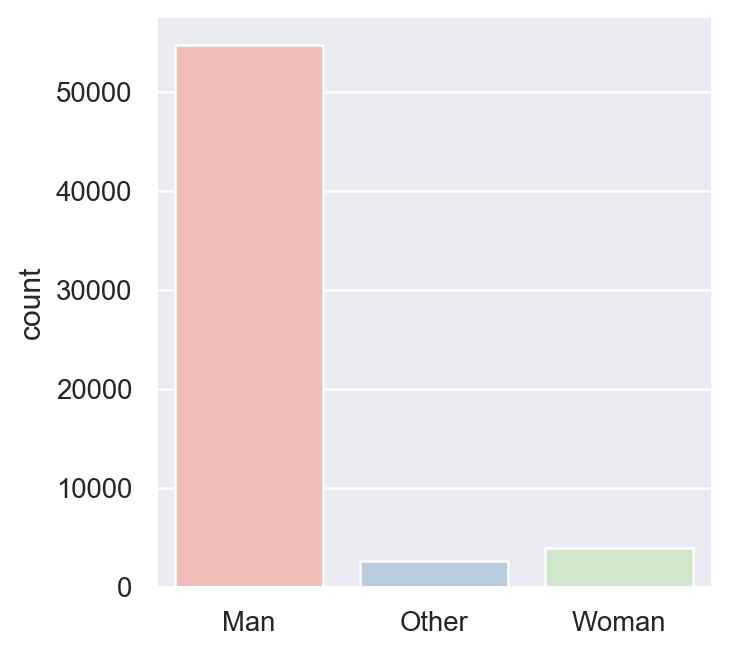

In [19]:
survey_dev['Gender'] = np.where(((survey_dev['Gender'] != 'Man') & (survey_dev['Gender'] != 'Woman')), 'Other', survey_dev['Gender'])

sns.catplot(x="Gender", kind="count", data=survey_dev,height = 4)
plt.xlabel("")

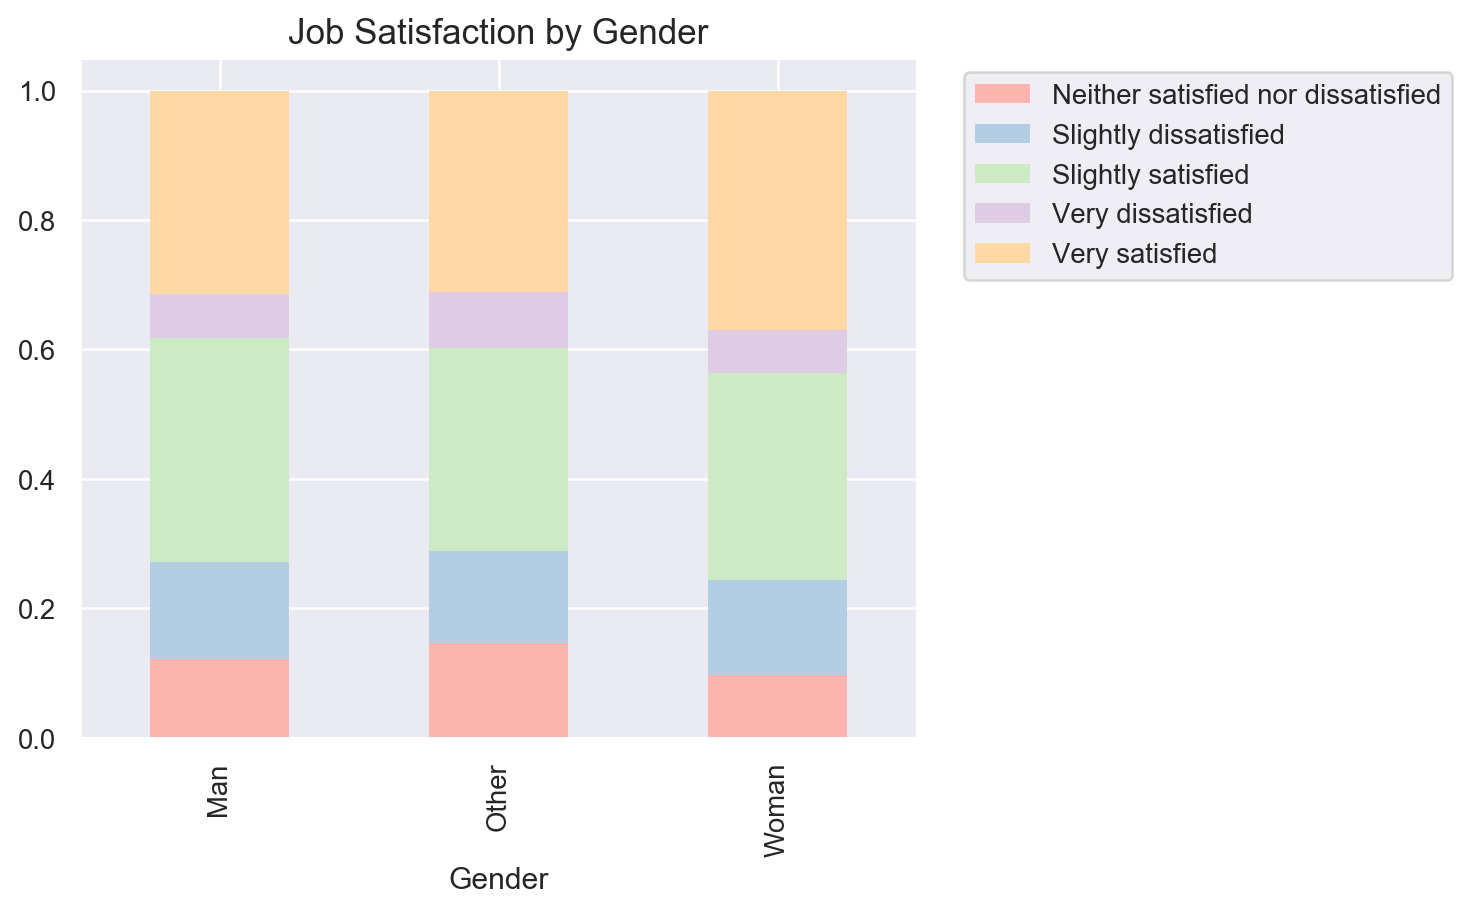

In [20]:
plotJobSatisfaction("Gender",width =6, height = 5)
plt.title('Job Satisfaction by Gender',fontsize = 14);

I don't feel comfortable making comments on any patterns that emerge from this plot, because I have such a small sample of women and non-binary people. There's no guarantee that any observations would generalize well.

In [21]:
survey_dev['AgeGroup'] = pd.cut(x=survey_dev['Age'], bins=[20, 29, 39, 49, 59, 69])

In [24]:
age_groups = np.delete(np.array(survey_dev['AgeGroup'].unique()),3)

In [25]:
age_percentage_data = percentageSatisfied(column = 'AgeGroup')

Text(0.5, 0, 'Age Group')

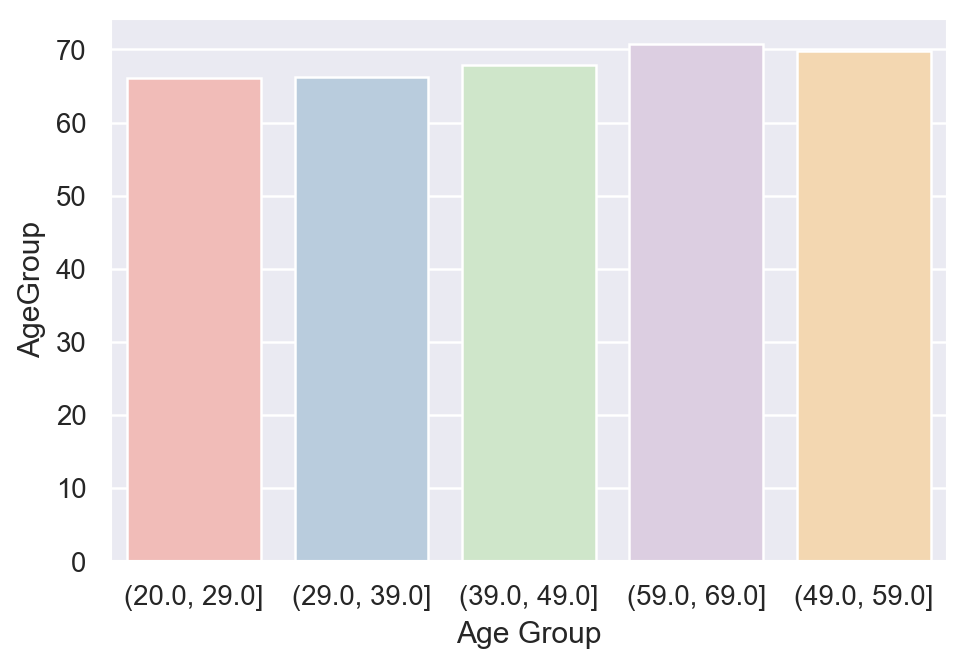

In [26]:
sns.barplot(y=age_percentage_data, x = age_groups)
plt.xlabel('Age Group')

### Education

C:\Users\hissi\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\hissi\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0, flags=flags)


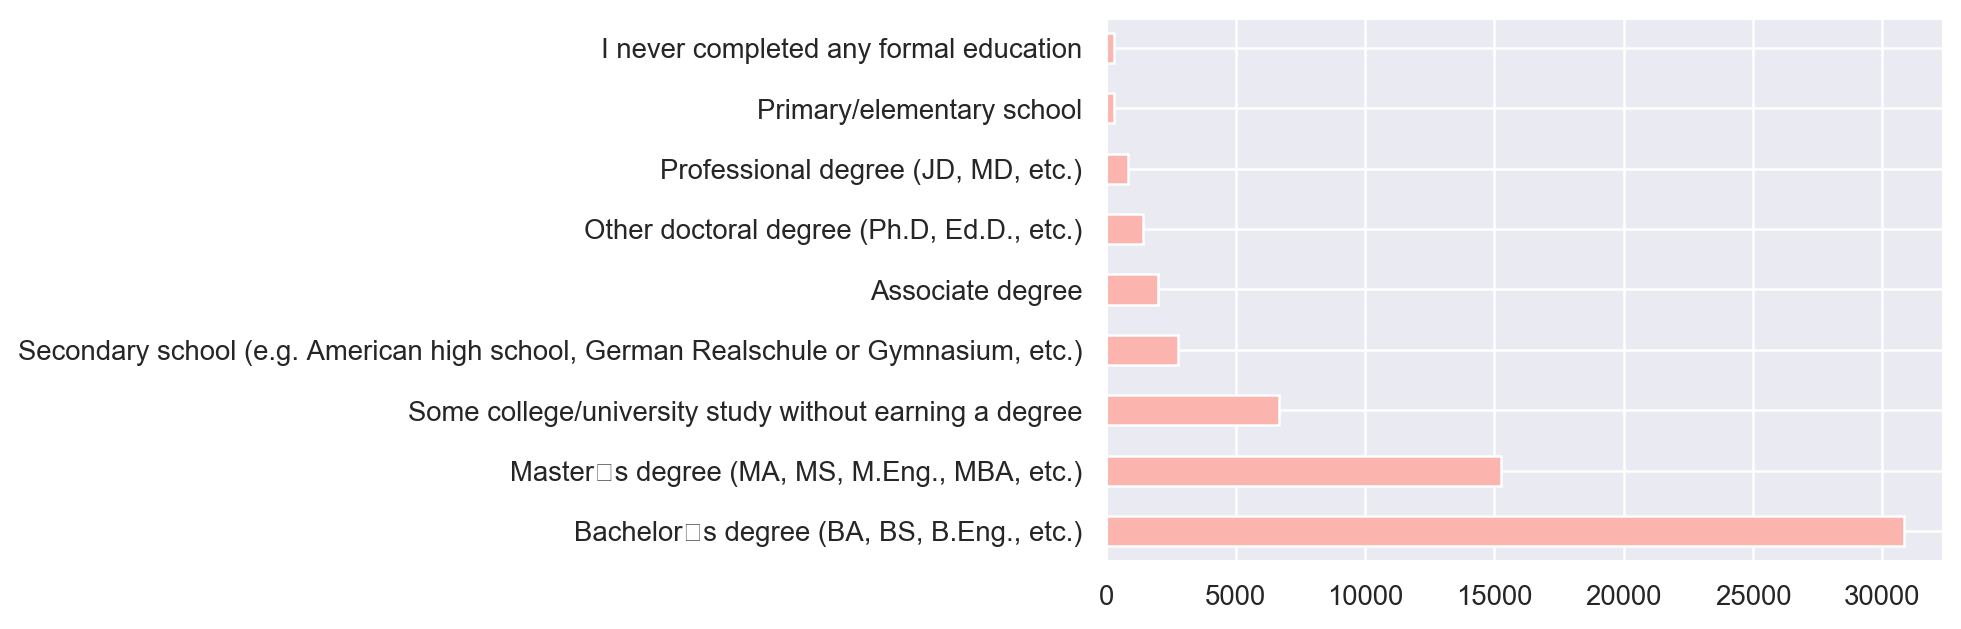

In [28]:
survey_dev['EdLevel'].value_counts().plot(kind='barh');

There's a column that I think contains a lot of interesting information: *EduOther*. The answers come from a multiple-choice question with the possibility of choosing more than one. This last factor complicates our analysis quite a lot.

The possible answers were:

* Taken an online course in programming or software development (e.g. a MOOC)

* Contributed to open source software (this information is already included in the *OpenSourcer* column, so I will ignore it)

* Taught yourself a new language, framework, or tool without taking a formal course

* Taken a part-time in-person course in programming or software development

* Participated in a hackathon

* Completed an industry certification program (e.g. MCPD)

* Participated in online coding competitions (e.g. HackerRank, CodeChef, TopCoder)

Even if it clearly cannot be used as it is, this column can still come in handy for us.
In particular, I would like to create a new **self-taught** category, that includes developers who meet ALL these conditions:

* don't have a STEM degree (most non-computer science STEM programs still have at least one programming course), except for health sciences majors

* didn't participate in a bootcamp or similar in-person programs

These conditions are pretty strict: I will still consider people who took online courses as self-taught. I'm curious to see if this new feature will show any correlation to job satisfaction. The part with the creation of the new feature will be in the next section of the article on *Feature Engineering*.

### Work-related

#### Organization size

Text(0.5, 0, 'Employees')

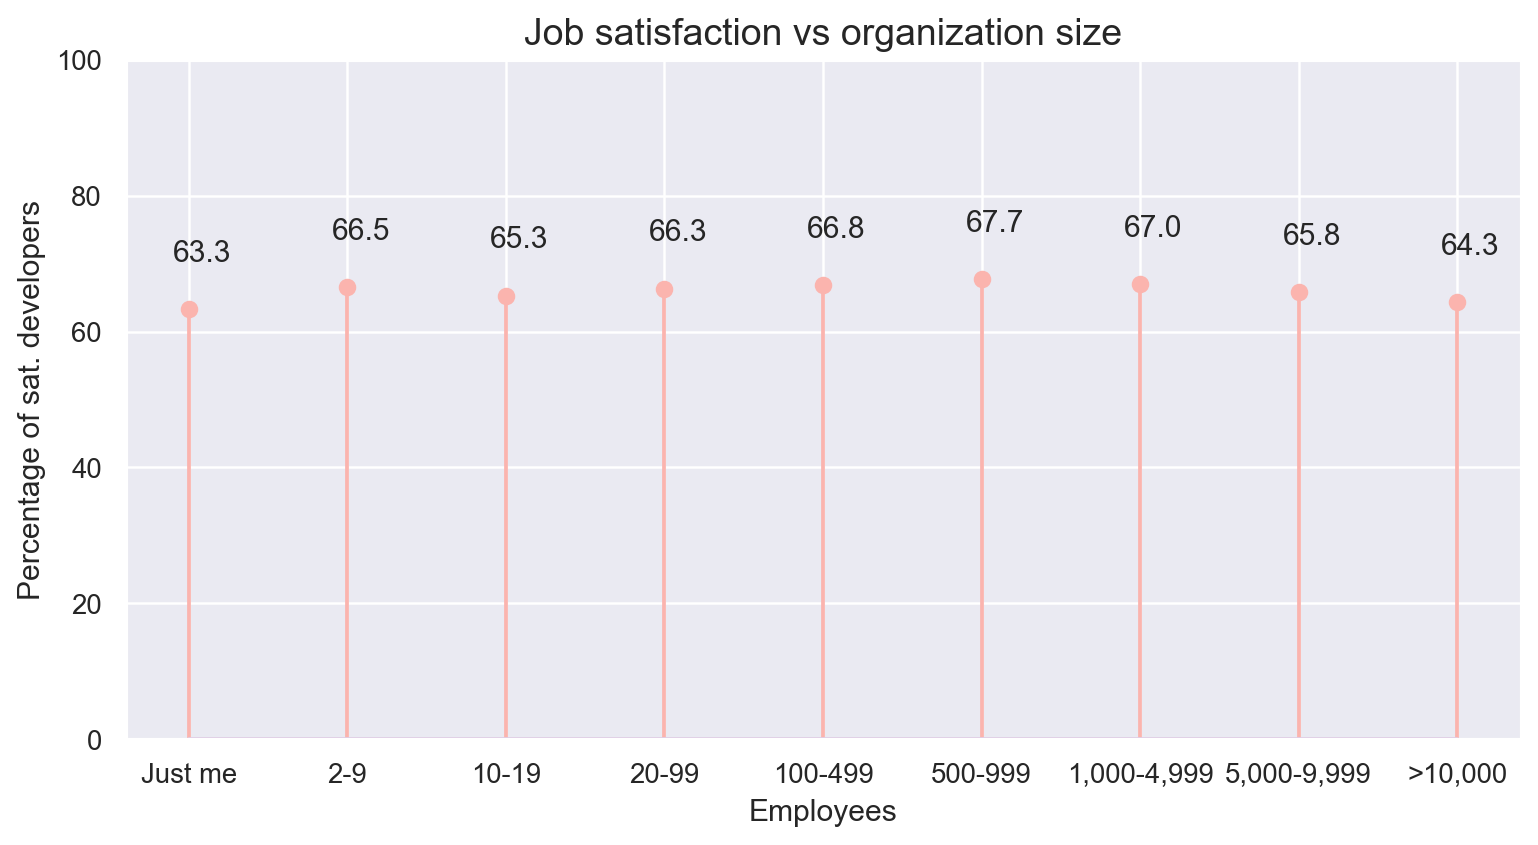

In [66]:
size_categories = ['Just me - I am a freelancer, sole proprietor, etc.','2-9 employees',
          '10 to 19 employees','20 to 99 employees','100 to 499 employees',
          '500 to 999 employees','1,000 to 4,999 employees', '5,000 to 9,999 employees',  '10,000 or more employees']
# The plots will look better with shorter category names
size_categories_short = ['Just me','2-9',
          '10-19','20-99','100-499',
          '500-999','1,000-4,999', '5,000-9,999',  '>10,000']


orgsize_satisfied = percentageSatisfied(column = 'OrgSize', dataset = survey_dev).reindex(size_categories)
plt.figure(figsize=(10,5))
lollipop(size_categories_short, orgsize_satisfied, xshift= -0.1)
plt.ylim(0,100);
plt.ylabel('Percentage of sat. developers')
plt.title('Job satisfaction vs organization size', fontsize = 15);
plt.xlabel('Employees')

There doesn't seem to be any strong correlation between the number of employees and job satisfaction.

#### Working remotely

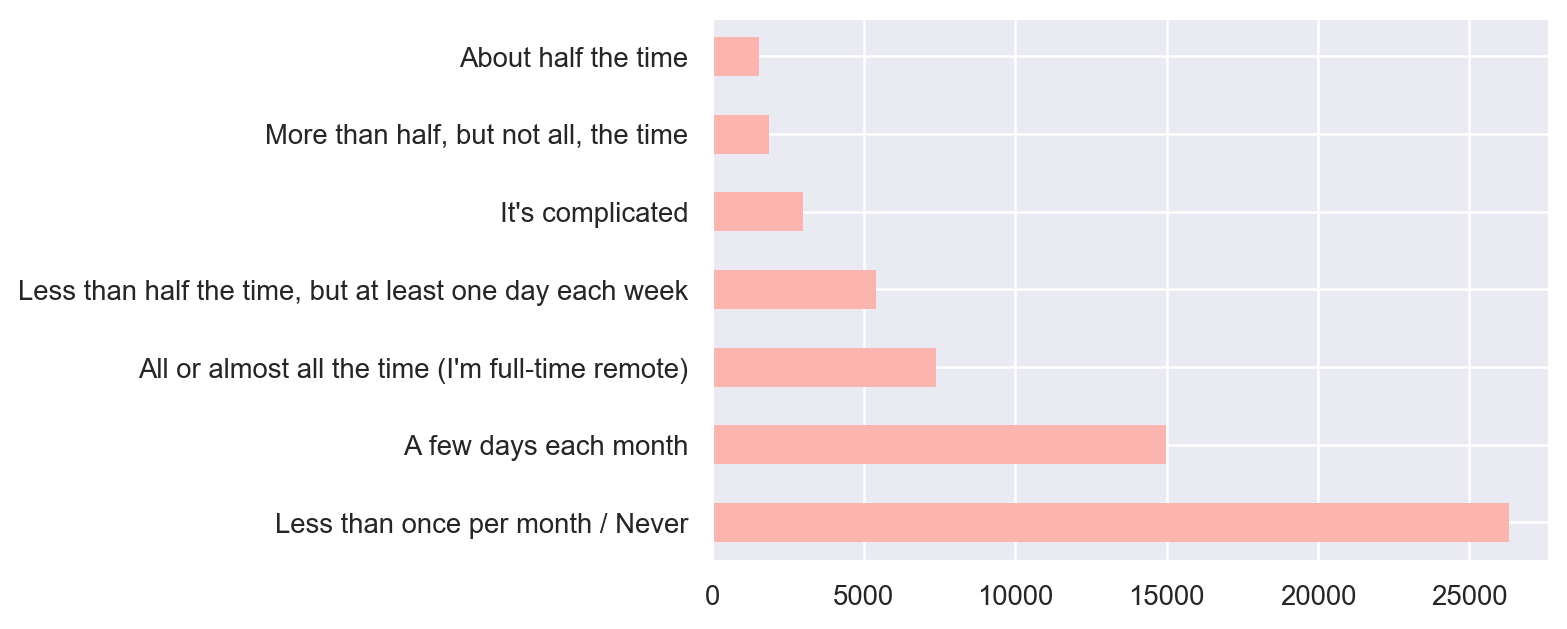

In [29]:
survey_dev['WorkRemote'].value_counts().plot(kind='barh',edgecolor = "none");

The WorkRemote field has way too many values for my taste, so I'm going to refactor this column, since I still think it will be interesting to study it. I want to end up with three categories: *full-time remote, sometimes remote, not remote*.

In [67]:
# new Remote column 
remote_cat = ['Not remote', 'Part-time remote', 'Full-time remote']
survey_dev = survey_dev.assign(Remote='Not remote')

full_time = (survey_dev['WorkRemote'].str.contains('all or almost'))
part_time = ( (survey_dev['WorkRemote'].str.contains('week'))
          | (survey_dev['WorkRemote'].str.contains('half'))
             | (survey_dev['WorkRemote'].str.contains('few')) )

survey_dev['Remote'] = np.where(full_time, 'Full-time remote', survey_dev['Remote'])
survey_dev['Remote'] = np.where(part_time, 'Part-time remote', survey_dev['Remote'])

survey_dev['Remote'].value_counts()

Not remote          36682
Part-time remote    23823
Full-time remote      868
Name: Remote, dtype: int64

Full-time remote developers are really rare, as I expected. Let's see if we can detect some satisfaction pattern.

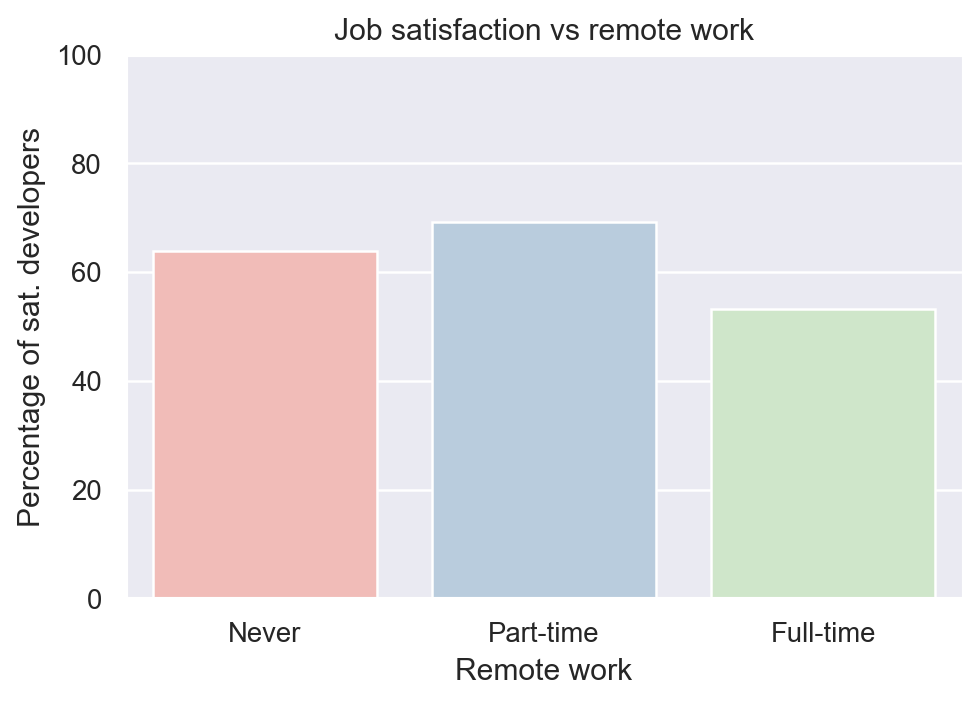

In [74]:
remote_cat_short = ['Never', 'Part-time', 'Full-time']
remote_satisfied = percentageSatisfied(column = 'Remote', dataset = survey_dev).reindex(remote_cat)
sns.barplot(y=remote_satisfied, x = remote_cat_short)
plt.xlabel('Remote work');
plt.ylim(0,100);
plt.ylabel('Percentage of sat. developers');
plt.title('Job satisfaction vs remote work');

#### Competence at work

We still haven't talked about the 'ImpSyn' column, which contains the answer to the question:

> For the specific work you do, and the years of experience you have, how do you rate your own level of competence?

I think competence is an interesting thing to look at in this context. Various influential thinkers (such as Robert Greene and [Cal Newport](https://www.calnewport.com/books/so-good/ "https://www.calnewport.com/books/so-good/")) believe that job satisfaction doesn't come from innate passion, but rather from *becoming very good at what you do*. If they are right we might see some correlation between these two variables.

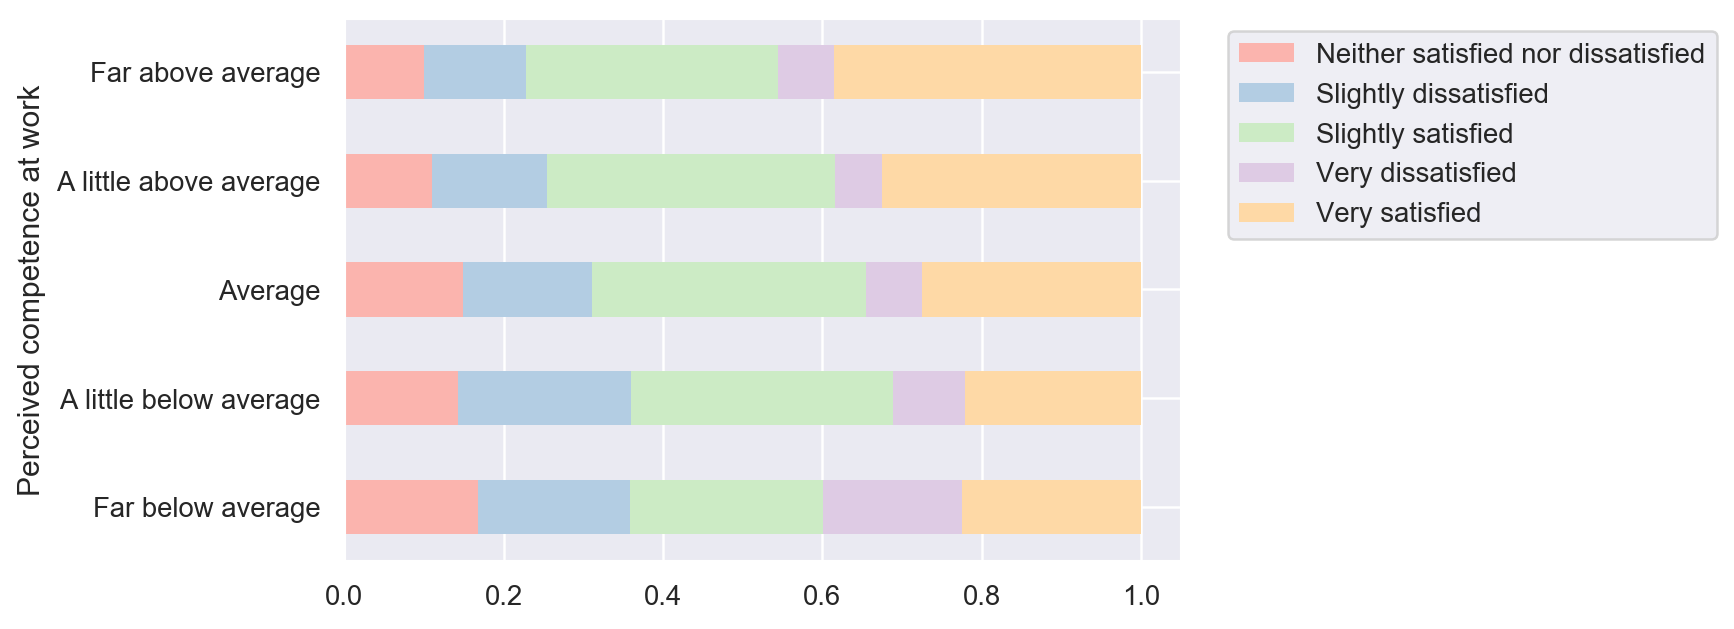

In [30]:
props = survey_dev.groupby('ImpSyn')['JobSat'].value_counts(normalize=True).unstack()
categories =  ["Far below average", "A little below average", "Average", "A little above average", "Far above average"]
props = props.reindex(categories)
props.plot(kind= 'barh', stacked='True',sort_columns = False,edgecolor= "none" )
plt.ylabel("Perceived competence at work")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left");

There's definitely **something there**. Developers who perceive themselves as having below average abilites are measurably less satisfied in their work compared to their more competent (or at least more confident) colleagues.

The difference is even more striking if we plot these competence categories against the percentage of developers who are in the *Satisfied* category.

Text(0.5, 0, 'Perceived competence')

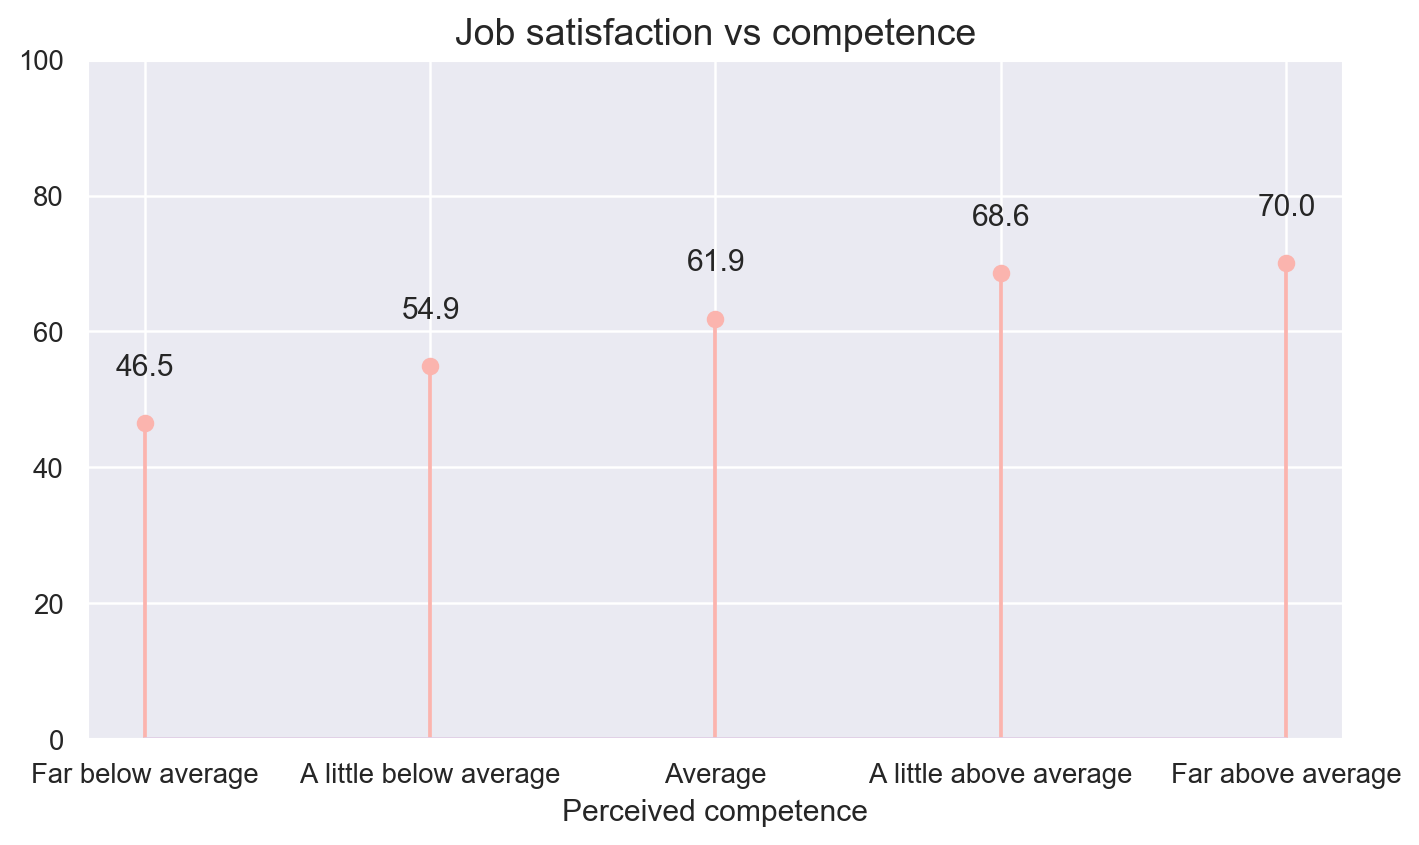

In [59]:
comp_satisfied = percentageSatisfied(column = 'ImpSyn', dataset = survey_dev).reindex(categories)
plt.figure(figsize=(9,5))
lollipop(categories, comp_satisfied, xshift= -0.1)
plt.ylim(0,100);
plt.title('Job satisfaction vs competence', fontsize = 15);
plt.xlabel('Perceived competence')

We can clearly see the fraction of satisfied developers growing with increasing competence.

### Other

#### Hobbyist developers

## Feature engineering

### Field of study 

Another thing I wonder is whether people who work in the field that they studied for are more satisfied than others. For developers, The "relevant" majors to consider would be (as they appear in the *UndergradMajor* column):
- Web development or web design (front-end and full-stack developers)
- Computer science, computer engineering, or software engineering 
- Information systems, information technology, or system administration 

I will also consider the subcategory of people who work in data science and studied Mathematics/Statistics, since they are technically working in their study fields.

In [ ]:
survey_dev = survey_dev.assign(SameField='No')
# Developers who have relevant majors
majors = ((survey_dev['UndergradMajor'].str.contains('web')) 
        |(survey_dev['UndergradMajor'].str.contains('computer'))
        | (survey_dev['UndergradMajor'].str.contains('information')) )
# Developers working in data 
data_scientist = ((survey_dev['DevType'].str.contains('Data scientist'))
                  & (survey_dev['UndergradMajor'].str.contains('statistics')))

survey_dev['SameField'] = np.where(majors, 'Yes', survey_dev['SameField'])
survey_dev['SameField'] = np.where(data_scientist, 'Yes', survey_dev['SameField'])


perc_dev = np.round(100*survey_dev.loc[survey_dev['SameField']=='Yes'].sum()/len(survey_dev))
print(str(perc_dev)+'% of developers in the survey come from a computer science or tech-related major.')


In [ ]:
survey_dev.loc[survey_dev['SameField']=='Yes']

In [158]:
survey_dev[survey_dev['SameField'] == 1]['UndergradMajor'].value_counts()

Computer science, computer engineering, or software engineering          37560
Information systems, information technology, or system administration     3719
Web development or web design                                             2496
Mathematics or statistics                                                  437
Name: UndergradMajor, dtype: int64

In [159]:
survey_dev[survey_dev['SameField'] == 0]['UndergradMajor'].value_counts()

Another engineering discipline (ex. civil, electrical, mechanical)      4287
A natural science (ex. biology, chemistry, physics)                     2007
Mathematics or statistics                                               1539
A business discipline (ex. accounting, finance, marketing)              1083
A humanities discipline (ex. literature, history, philosophy)           1079
Fine arts or performing arts (ex. graphic design, music, studio art)     865
A social science (ex. anthropology, psychology, political science)       837
I never declared a major                                                 604
A health science (ex. nursing, pharmacy, radiology)                      134
Name: UndergradMajor, dtype: int64

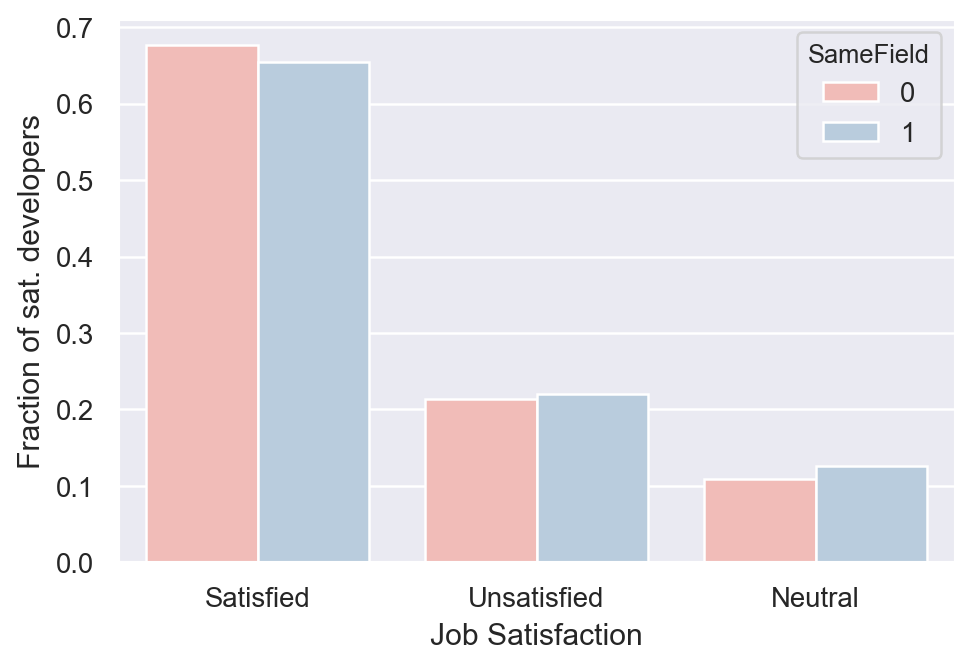

In [108]:
grouped_bars_fraction(y ="Fraction of sat. developers", x="Satisfaction" , hue = "SameField")
plt.xlabel('Job Satisfaction');


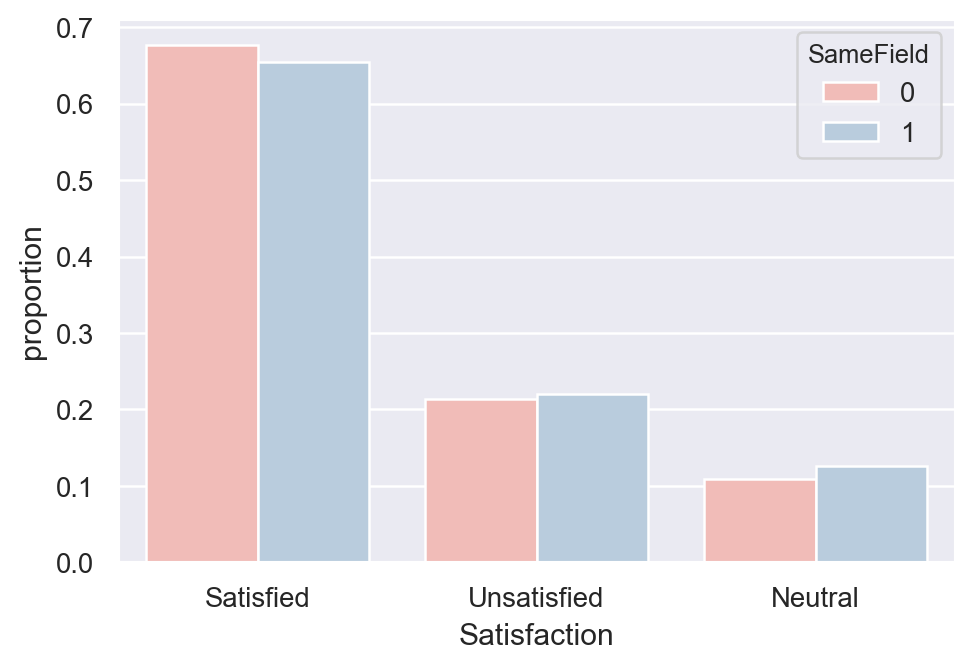

In [95]:
survey_dev['Satisfaction'].groupby(survey_dev['SameField']).value_counts(normalize=True).rename('proportion').reset_index().pipe((sns.barplot, "data"), x='Satisfaction', y='proportion', hue='SameField')

### Remote work

### Self-taught developers

In [ ]:
survey_dev['UndergradMajor'].value_counts()

In [78]:
not_self_taught = ((survey_dev['EduOther'].str.contains('bootcamp')) | (survey_dev['UndergradMajor'].str.contains('never'))
                        | (survey_dev['UndergradMajor'].str.contains('natural'))
                        | (survey_dev['UndergradMajor'].str.contains('computer'))
                        | (survey_dev['UndergradMajor'].str.contains('information'))
                        | (survey_dev['UndergradMajor'].str.contains('web'))
                        | (survey_dev['UndergradMajor'].str.contains('Mathematics'))
                        | (survey_dev['UndergradMajor'].str.contains('electrical')))


survey_dev = survey_dev.assign(SelfTaught=1)
survey_dev['SelfTaught'] = np.where(not_self_taught, 0, survey_dev['SelfTaught'])

In [ ]:
survey_dev[survey_dev['SelfTaught'] == 1]['UndergradMajor'].value_counts()

We end up with about **6000 self-taught developers** according to our criteria.

In [77]:
plotJobSatisfaction("SelfTaught",5,5)

KeyError: 'SelfTaught'

Mmmm...seems like there's not much to see here. We will check this later when we build the model and measure relative feature importance.

### Job level

Unfortunately we don't have data on job levels (junior,senior, etc). The closest thing to that is the number of years spent coding as a professional, and the *MgrWant* column. The column contains the answer to "Would you like to become a manager some day?", and it  also includes the precious answer of those who are already managers.

Of course, a developer can be employed at a high level without being in a managerial position - think architects and other technical leads, but this is as close as we can get to the answer.

In [152]:
# New binary 'manager' column 
survey_dev = survey_dev.assign(Manager=0)
survey_dev['Manager'] = np.where( (survey_dev['MgrWant'].str.contains('manager')),1, survey_dev['Manager'])

In [153]:
print(f"There are {survey_dev['Manager'].sum()} managers among the survey takers.")

There are 12013 managers among the survey takers.


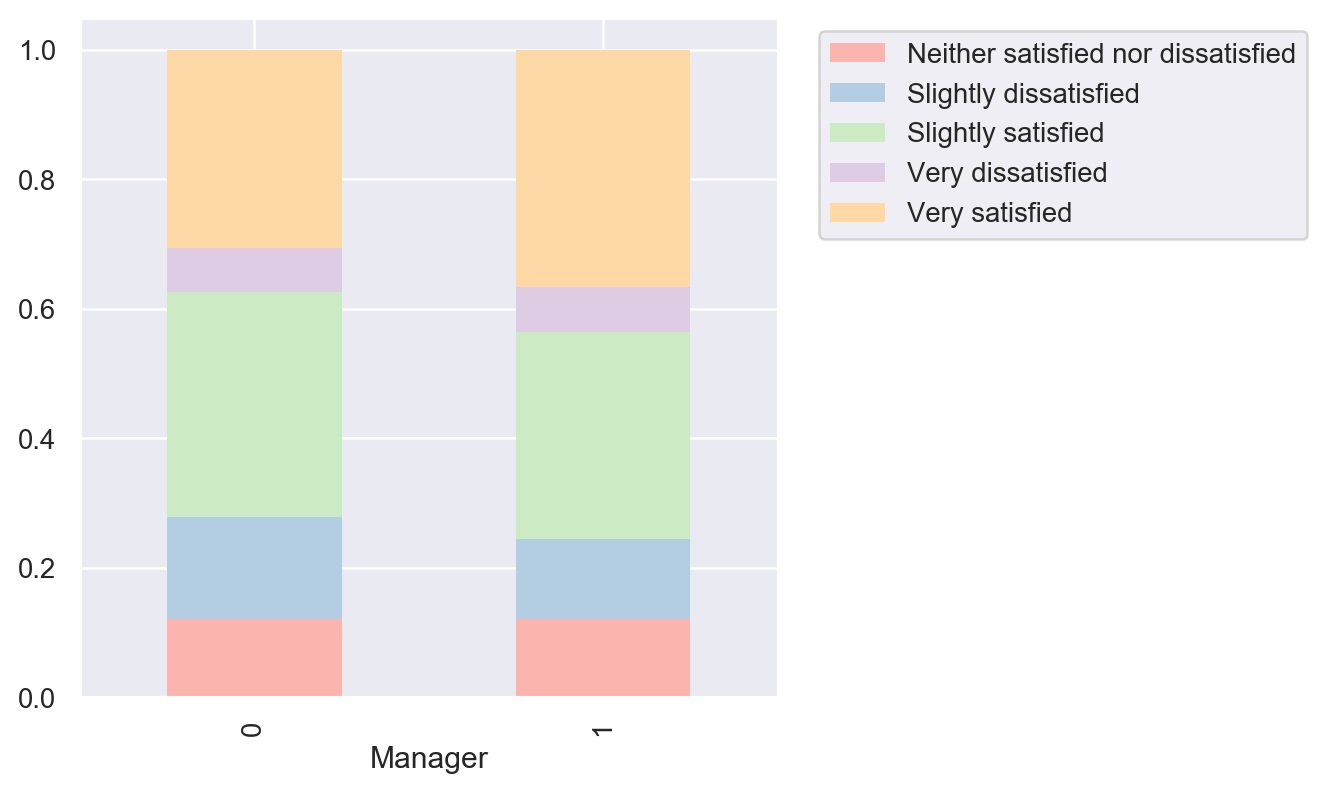

In [165]:
plotJobSatisfaction(column = "Manager", norm =True)

*Comments*

bla bla bla